<a href="https://colab.research.google.com/github/mr-ayush-agrawal/DL_Notebooks/blob/main/HotDog_classification/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hot Dog or Not

Taking reference from the vidoe of [Fcc](https://www.youtube.com/watch?v=nVhau51w6dM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models

We are using the sample dataset of `food101` which is present in the tensorflow

In [2]:
# load_dataset = False
# ds, ds_info = [],[]instead
if load_dataset :
  ds, ds_info = tfds.load('food101', shuffle_files = True, as_supervised = True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.ZG70FC_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.ZG70FC_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpw71h_tq2tfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [4]:
train_ds, val_ds = ds['train'], ds['validation']

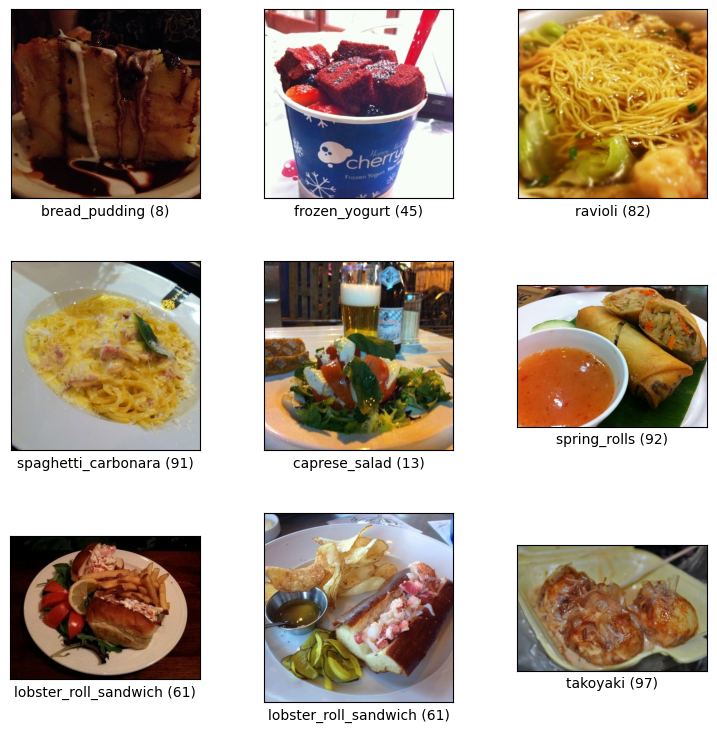

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
len(train_ds), len(val_ds)

(75750, 25250)

### Resizing the imges

In [7]:
MAX_SIDE = 128
HOTDOG = 55
train_ds = train_ds.map(
    lambda image, label : (tf.cast(tf.image.resize(image, [MAX_SIDE, MAX_SIDE]), tf.int32),
                           tf.cast(label == HOTDOG, tf.int32))
)
val_ds = val_ds.map(
    lambda image, label : (tf.cast(tf.image.resize(image, [MAX_SIDE, MAX_SIDE]), tf.int32),
                           tf.cast(label == HOTDOG, tf.int32))
)

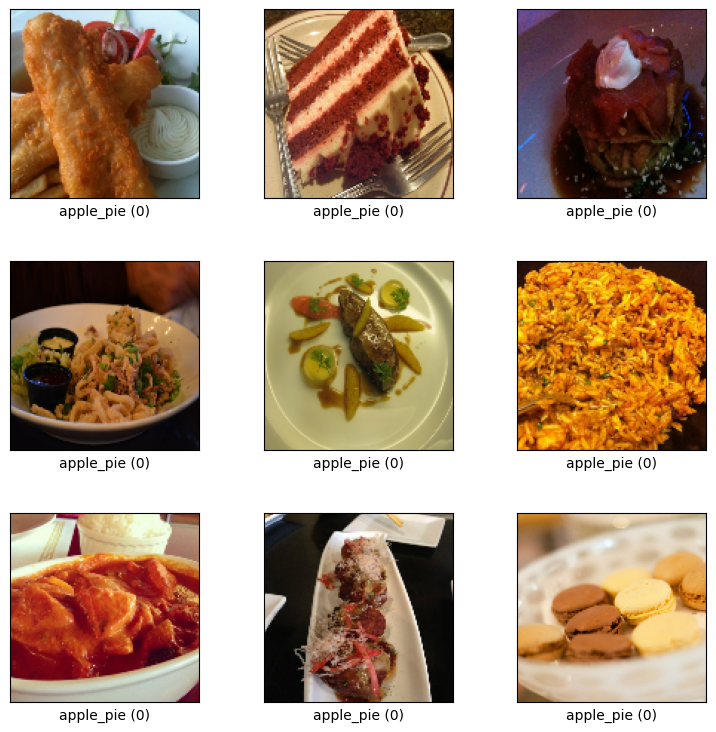

In [8]:
fig = tfds.show_examples(train_ds, ds_info)

We are getting the wrong labels as all are naming as apple_pie as we set all the non-hotdog labels to 0

### Rebalancing the dataset
There are many non-hotdog images as compared to the hotdog, we need to balance out the dataset.

In [9]:
# Available in documentation of the dataset
train_hd_size, val_hd_size = 750, 250
train_hotdog = train_ds.filter(lambda image, label : label == 1).repeat(3)  # Up-sampling it
train_nothotdog = train_ds.filter(lambda image, label : label == 0)


In [10]:
val_hotdog = val_ds.filter(lambda image, label : label == 1).repeat(3)  # Up-sampling it
val_nothotdog = val_ds.filter(lambda image, label : label == 0)

Even after increasing the number of data images for hotdog still there is huge difference in the number of the images present. So, we are resampling it

In [13]:
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdog, train_nothotdog],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset= True)

batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
val_ds = tf.data.Dataset.sample_from_datasets([val_hotdog, val_nothotdog],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset= True)

val_ds = val_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
# printing one batch. There are 16 images in 1 batch of tensor
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [101 116 123]
   [124 137 145]
   [141 152 156]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [ 80  95 102]
   [ 94 107 115]
   [107 118 122]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [136 146 147]
   [138 149 153]
   [136 145 142]]

  ...

  [[134  25  28]
   [134  25  28]
   [134  25  28]
   ...
   [158  51  69]
   [159  52  68]
   [160  53  68]]

  [[129  25  24]
   [133  24  26]
   [135  25  27]
   ...
   [154  46  62]
   [157  49  65]
   [160  52  67]]

  [[130  26  22]
   [133  25  23]
   [134  24  23]
   ...
   [155  48  67]
   [157  50  70]
   [159  52  73]]]


 [[[  0   7   6]
   [  0   6   6]
   [  0   4   5]
   ...
   [115 151 208]
   [115 153 208]
   [118 158 208]]

  [[  0   5   4]
   [  2   8   8]
   [  0   4   5]
   ...
   [111 146 202]
   [109 146 200]
   [112 151 201]]

  [[  0   6   5]
   [  1   7   7]
   [  1   6   6]
   ...
   [116 150 205]
   [111 147 200]


## Neural Network Implementation

### Data Agumentation Layer
Making and testing the Layer for Data agumentation where we will rotate the images to provide better dataset for training.

In [32]:
# Data Agumentation Layer
data_agumentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
])

(-0.5, 511.5, 305.5, -0.5)

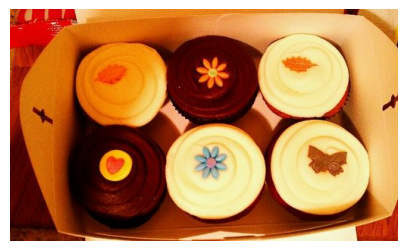

In [33]:
# taknig 1 image and showing it
for i, _ in ds['train'].take(1) :
  image = i
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')

In [34]:
# how it works
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

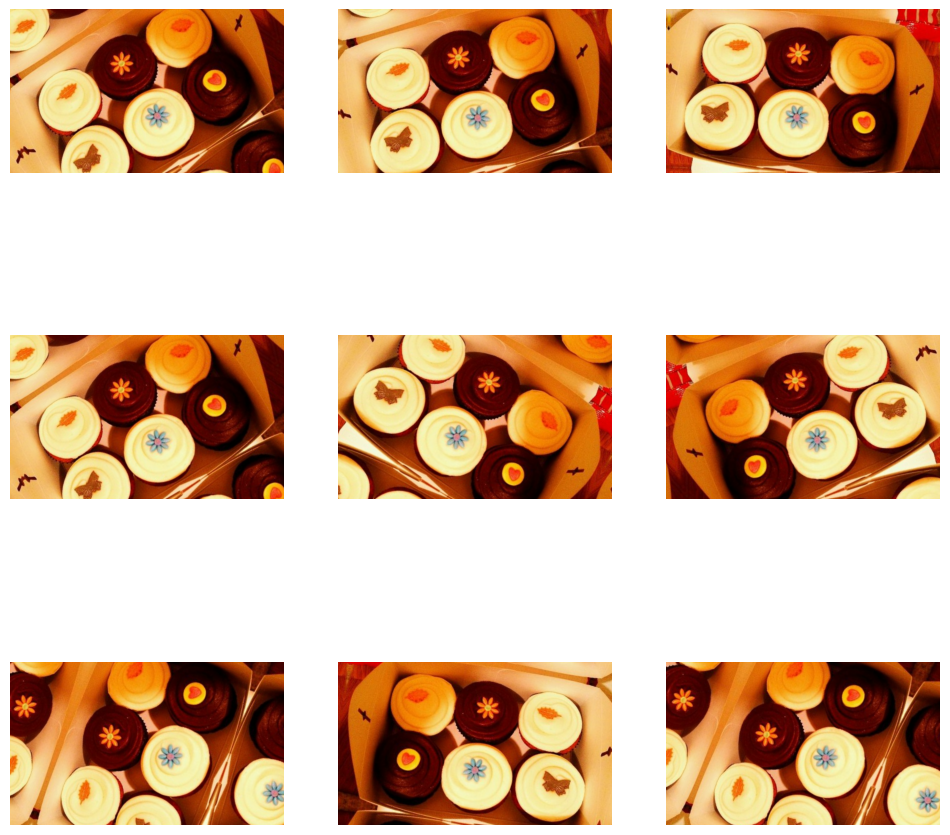

In [35]:
plt.figure(figsize=(12,12))
for i in range(9):
  agumented_image = data_agumentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(agumented_image[0])
  plt.axis('off')

### Model building
For making the model we are using the CNN 2D layers

In [37]:
model = models.Sequential()

model.add(layers.Rescaling(1./255))  # use for rescaling the Images in range from [0,255] -> [0,1]
model.add(data_agumentation)

model.add(layers.Conv2D(64, (3,3), activation = 'relu',  input_shape = [MAX_SIDE, MAX_SIDE, 3]))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [38]:
lr = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),    # its true as final layer output is not in range of [0,1]
              metrics=['accuracy'])

In [39]:
# Testing the model without training
# model.evaluate(train_ds)
# roughly about 50%

In [40]:
%%time
epochs = 50
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    verbose = 1
)

Epoch 1/50
284/284 [==============================] - 191s 664ms/step - loss: 1.2492 - accuracy: 0.5094 - val_loss: 1.0816 - val_accuracy: 0.4970
Epoch 2/50
284/284 [==============================] - 185s 652ms/step - loss: 0.9833 - accuracy: 0.5169 - val_loss: 0.9002 - val_accuracy: 0.5023
Epoch 3/50
284/284 [==============================] - 185s 653ms/step - loss: 0.8543 - accuracy: 0.5426 - val_loss: 0.8133 - val_accuracy: 0.5198
Epoch 4/50
284/284 [==============================] - 183s 645ms/step - loss: 0.7925 - accuracy: 0.5521 - val_loss: 0.7663 - val_accuracy: 0.5526
Epoch 5/50
284/284 [==============================] - 185s 650ms/step - loss: 0.7534 - accuracy: 0.5717 - val_loss: 0.7345 - val_accuracy: 0.5667
Epoch 6/50
284/284 [==============================] - 184s 648ms/step - loss: 0.7292 - accuracy: 0.5799 - val_loss: 0.7001 - val_accuracy: 0.6271
Epoch 7/50
284/284 [==============================] - 186s 656ms/step - loss: 0.7133 - accuracy: 0.5881 - val_loss: 0.6869 -

In [52]:
for image_batch, label_batch in val_ds.take(1) :
  images = image_batch
  labels = label_batch

<Figure size 2000x2000 with 0 Axes>

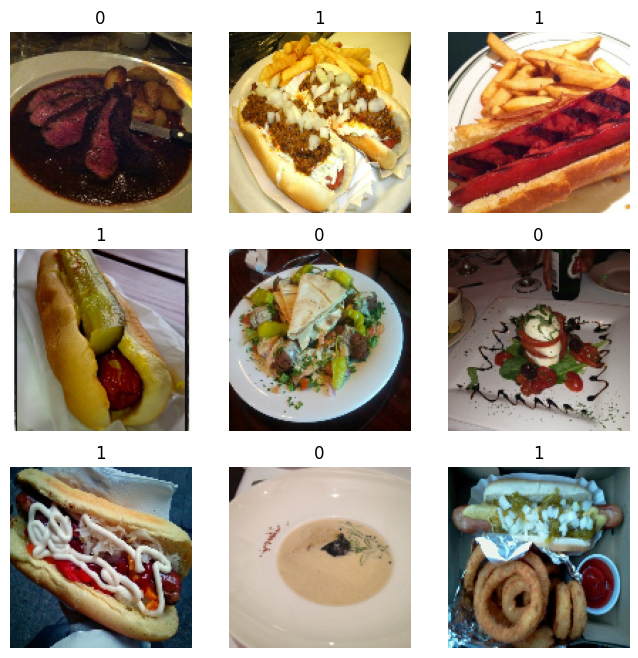

In [57]:
plt.figure(figsize = (8, 8))
for i in range(9) :
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.title(str(labels[i].numpy()))
  plt.axis('off')